In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import missingno

from catboost import CatBoostClassifier
from sklearn.metrics import precision_score, recall_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report

In [10]:
PROCESSED_PATH = "/Users/shiryaevva/HSE/2-nd_year/nhl-ml-project/nhl_project/data/processed/"
REPORTING_PATH = "/Users/shiryaevva/HSE/2-nd_year/nhl-ml-project/nhl_project/data/dwh/vault/reporting/"

In [11]:
teams_stat = pd.read_csv(REPORTING_PATH + 'teams_statistics.csv')
teams_stat.head()

,date,season_id,team_business_id,conference_home_sequence,conference_l10_sequence,conference_road_sequence,conference_sequence,division_home_sequence,division_l10_sequence,division_road_sequence,...,win_pctg,wins,_source_load_datetime,_source_is_deleted,_source,_batch_id,team_id,team_source_id,conference_name,division_name
0,2012-01-01,20112012,BOS,2,1,2,2,1,1,1,...,0.685714,24,2012-01-01 00:00:00,False,API_NHL,2024-03-24,0bd9564a48ab0de04df8e876d1a1de3c6d4e30f2,6,Eastern,Atlantic
1,2012-01-01,20112012,PHX,13,11,2,11,4,4,1,...,0.487179,19,2012-01-01 00:00:00,False,API_NHL,2024-03-24,1ce51de9db580729e7833191b1d0daf6600f801e,27,Western,Pacific
2,2012-01-01,20112012,VAN,9,5,1,2,3,2,1,...,0.615385,24,2012-01-01 00:00:00,False,API_NHL,2024-03-24,294224f05292070f79b3a86048602d3fc2ef129e,23,Western,Pacific
3,2012-01-01,20112012,TBL,8,7,12,12,4,3,3,...,0.459459,17,2012-01-01 00:00:00,False,API_NHL,2024-03-24,384c73fcd755def9f5750f2ab52fceb3165b718a,14,Eastern,Atlantic
4,2012-01-01,20112012,TOR,11,12,7,10,4,3,2,...,0.473684,18,2012-01-01 00:00:00,False,API_NHL,2024-03-24,430e84f2b6d2c4f1dd22d50047f1fe24dc05c263,10,Eastern,Atlantic


In [12]:
df_games = pd.read_csv(PROCESSED_PATH + 'games_statistics_wide.csv').sort_values(by='game_date')
df_games.head()

,game_source_id,game_date,season,home_team_code,visiting_team_code,game_type,home_score,visiting_score,score_delta,h_conference_home_sequence,...,v_streak_count,v_ties,v_waivers_sequence,v_wildcard_sequence,v_win_pctg,v_wins,v_conference_name,v_division_name,home_team_winner,game_month
0,2011020572,2012-01-02,20112012,VAN,SJS,2,2,3,-1,9,...,1,0,23,0,0.558824,19,Western,Pacific,0,1
1,2011020571,2012-01-02,20112012,CHI,EDM,2,3,4,-1,4,...,3,0,5,0,0.405405,15,Western,Pacific,0,1
2,2011020570,2012-01-02,20112012,OTT,NJD,2,3,2,1,7,...,2,0,17,0,0.567568,21,Eastern,Metropolitan,1,1
3,2011020573,2012-01-02,20112012,LAK,COL,2,1,2,-1,10,...,2,0,10,0,0.525000,21,Western,Central,0,1
4,2011020569,2012-01-02,20112012,PHI,NYR,2,2,3,-1,14,...,1,0,29,0,0.638889,23,Eastern,Metropolitan,0,1


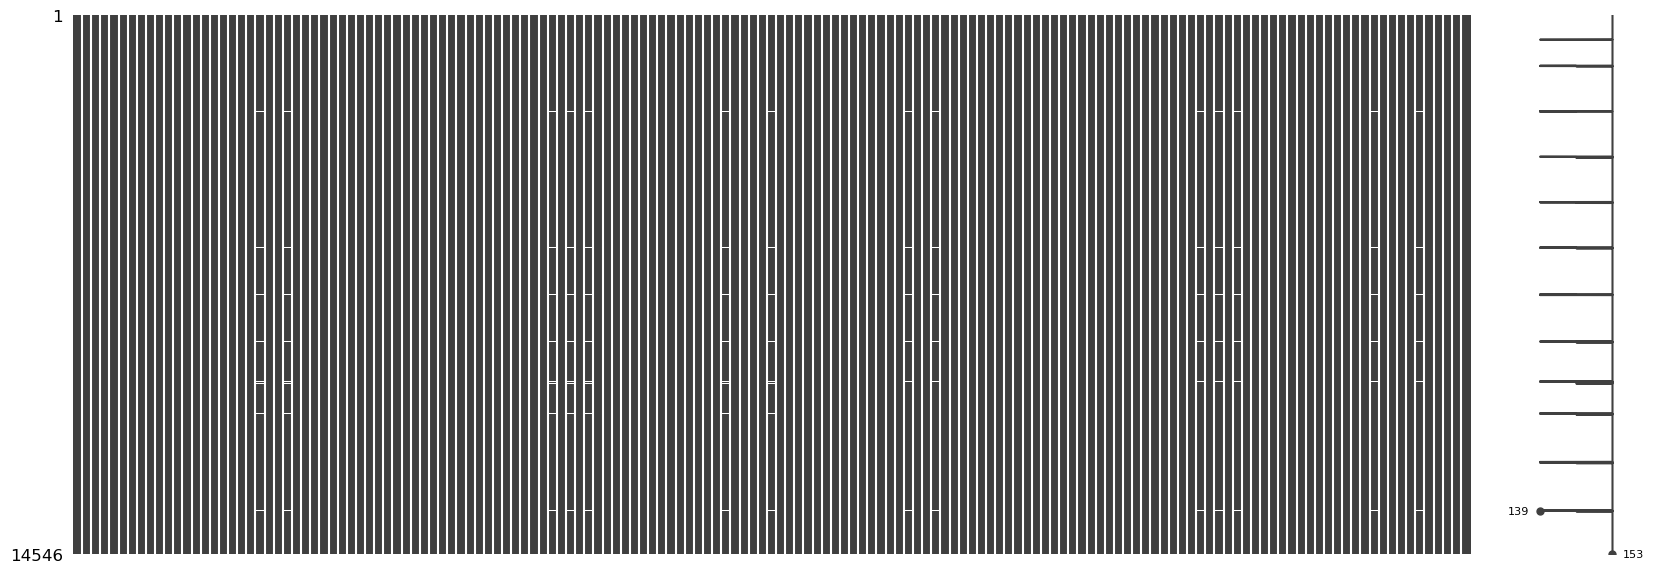

In [13]:
missingno.matrix(df_games, figsize=(20, 7), label_rotation=45, fontsize=10);

In [14]:
df_games.dropna(inplace=True)

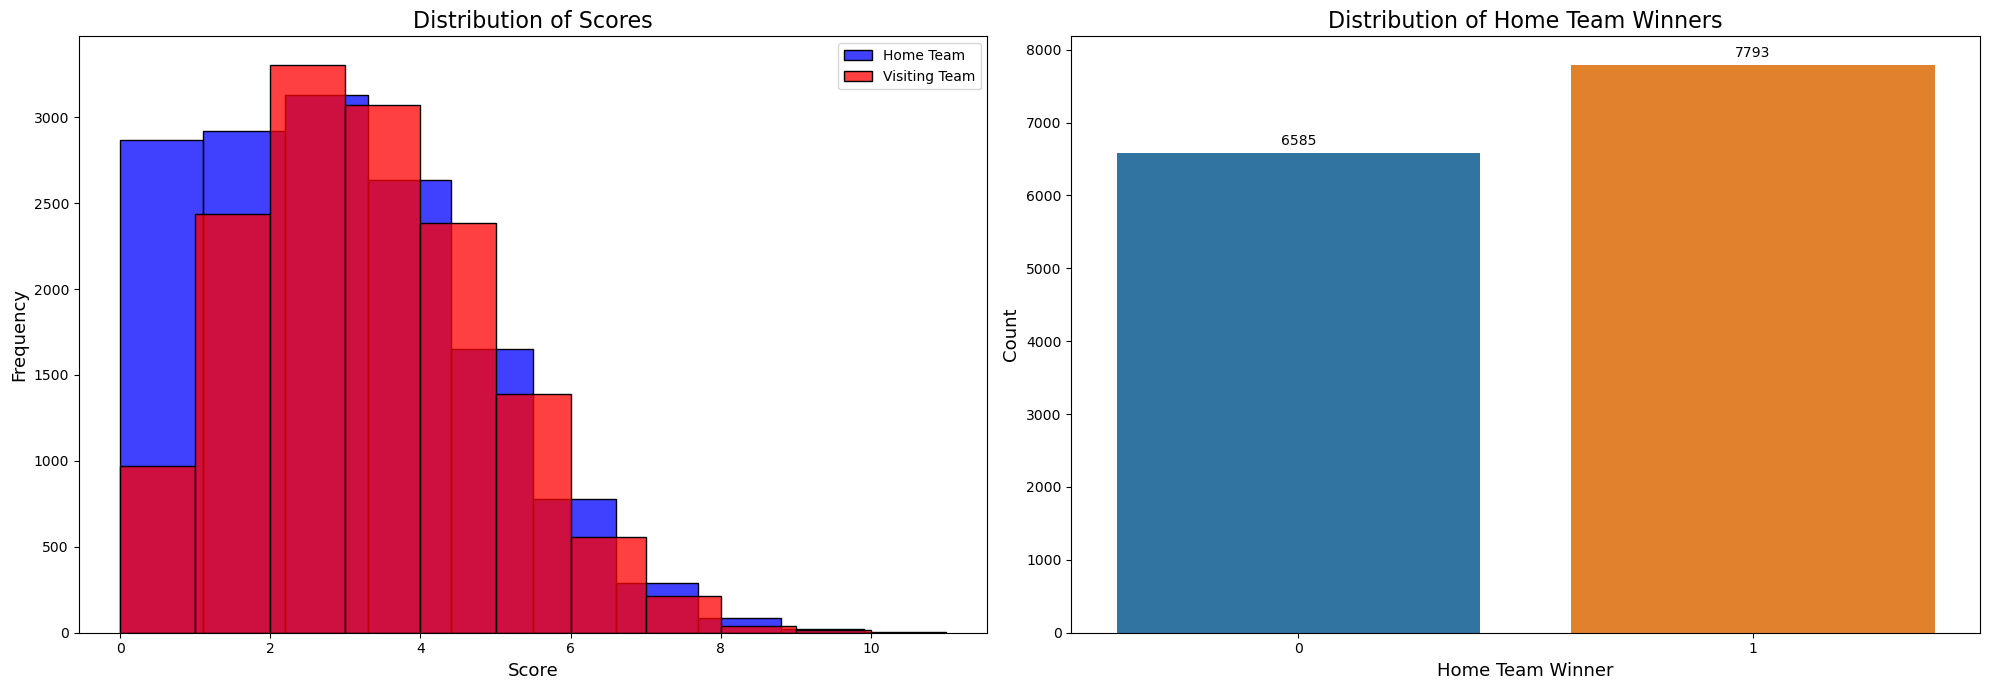

In [15]:
plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
sns.histplot(data=df_games, x='home_score', bins=10, color='blue', label='Home Team')
sns.histplot(data=df_games, x='visiting_score', bins=10, color='red', label='Visiting Team')
plt.title('Distribution of Scores', fontsize=16)
plt.xlabel('Score', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.legend()


plt.subplot(1, 2, 2)
ax = sns.countplot(data=df_games, x='home_team_winner')

for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 100, 
            rect.get_height(), horizontalalignment='center', fontsize = 10)
    
plt.title('Distribution of Home Team Winners', fontsize=16)
plt.xlabel('Home Team Winner', fontsize=13)
plt.ylabel('Count', fontsize=13)

plt.tight_layout()
plt.show()


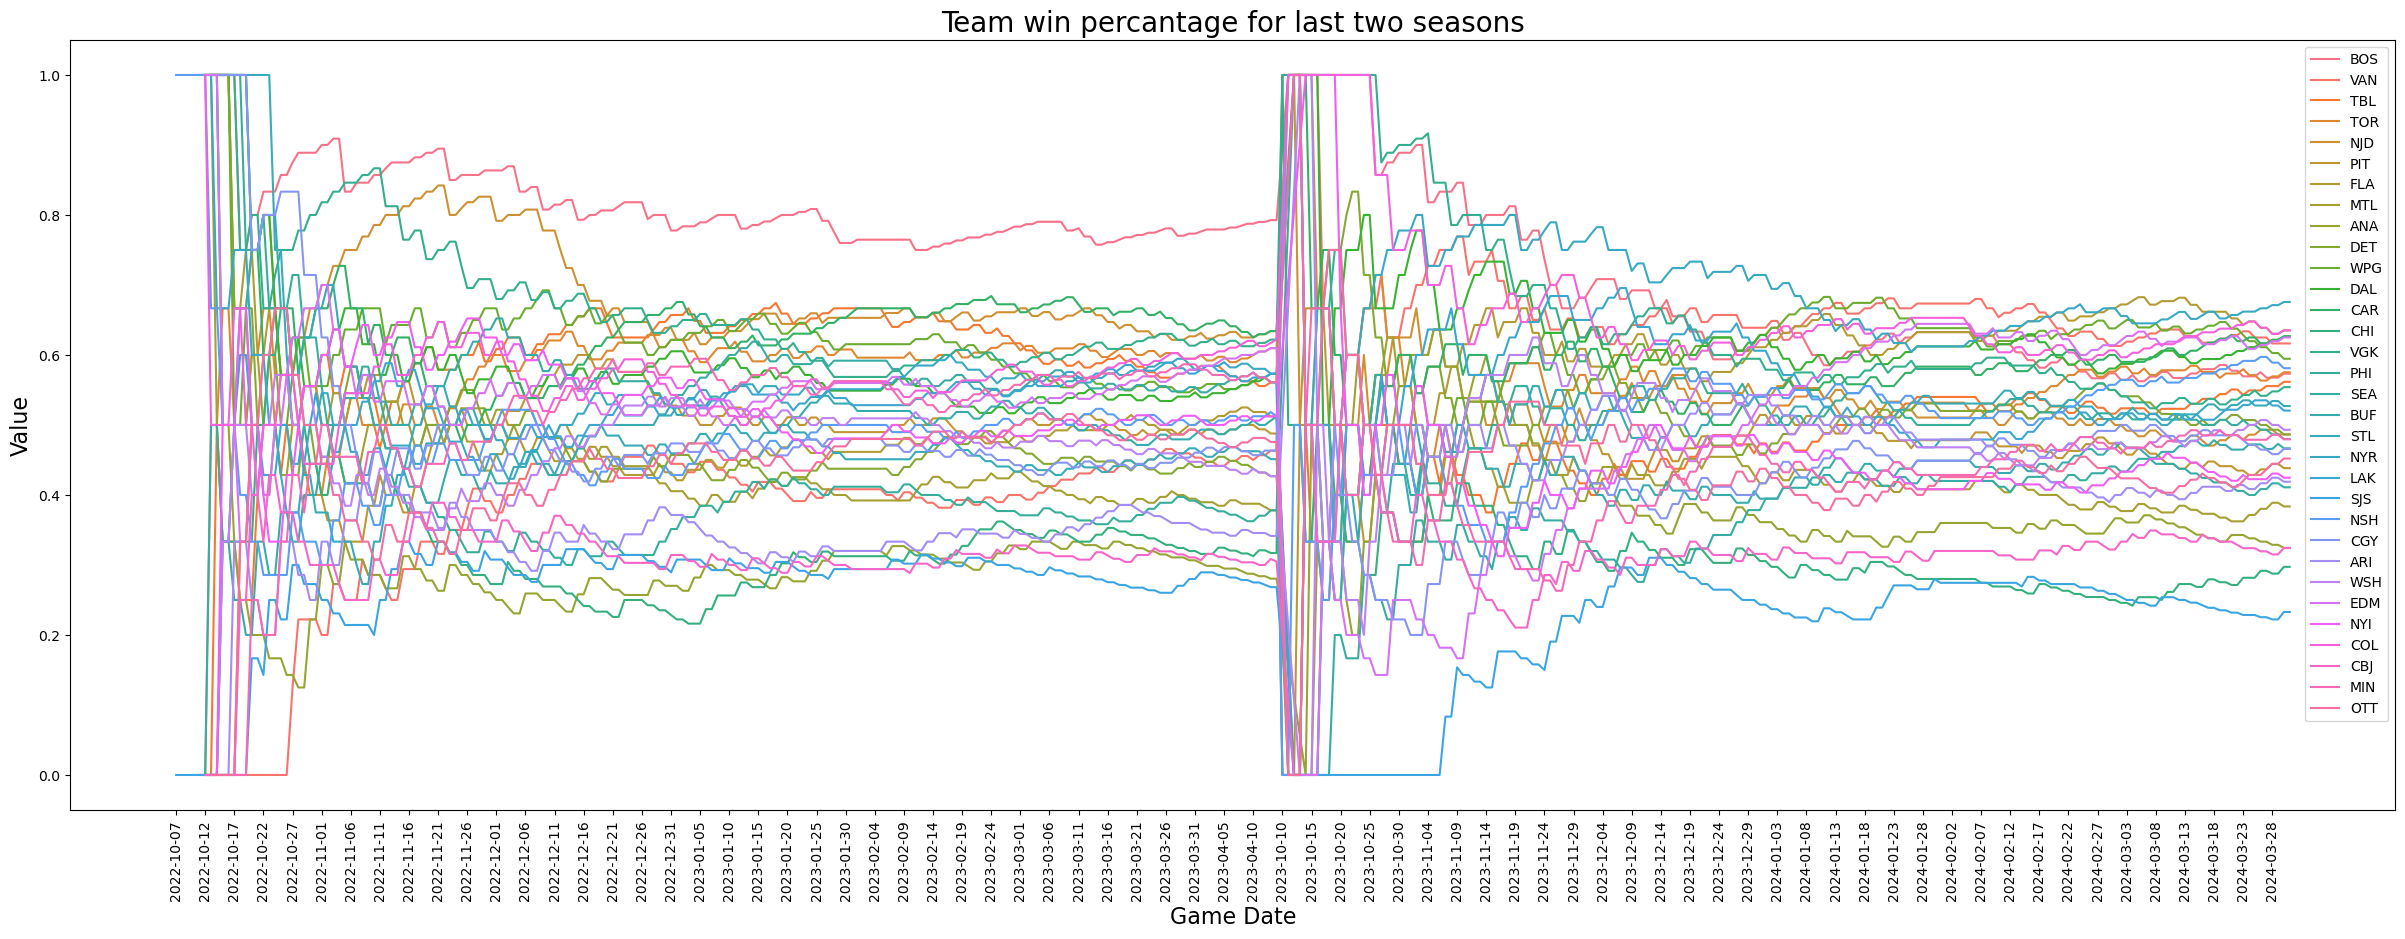

In [16]:
all_dates = teams_stat[(teams_stat.season_id >= 20222023)]['date'].unique()
selected_dates = all_dates[::5]

plt.figure(figsize=(30, 10))
sns.lineplot(data=teams_stat[(teams_stat.season_id >= 20222023)], hue='team_business_id', x='date', y='win_pctg', color='red')

plt.title('Team win percantage for last two seasons', fontsize=20)
plt.xlabel('Game Date', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.xticks(selected_dates, rotation=90)
plt.legend()
plt.show()

## Разделим данные на train и test

In [49]:
df_games = df_games.sort_values(by='game_date')

test_index = int(0.2 * len(df_games))

df_train = df_games.iloc[:-test_index]
df_test = df_games.iloc[-test_index:]

In [50]:
X_train = df_train.drop(columns=["game_source_id",
                                 "game_date",
                                 "game_type",
                                 "score_delta",
                                 "home_team_winner",
                                 "home_score",
                                 "visiting_score",])
y_train = df_train.home_team_winner

X_test = df_test.drop(columns=["game_source_id",
                               "game_date",
                                "game_type",
                                "score_delta",
                                "home_team_winner",
                                "home_score",
                                "visiting_score",])

y_test = df_test.home_team_winner

X_train.head()

,season,home_team_code,visiting_team_code,h_conference_home_sequence,h_conference_l10_sequence,h_conference_road_sequence,h_conference_sequence,h_division_home_sequence,h_division_l10_sequence,h_division_road_sequence,...,v_streak_code,v_streak_count,v_ties,v_waivers_sequence,v_wildcard_sequence,v_win_pctg,v_wins,v_conference_name,v_division_name,game_month
0,20112012,VAN,SJS,9,5,1,2,3,2,1,...,OT,1,0,23,0,0.558824,19,Western,Pacific,1
1,20112012,CHI,EDM,4,1,3,1,2,1,1,...,L,3,0,5,0,0.405405,15,Western,Pacific,1
2,20112012,OTT,NJD,7,8,8,8,2,2,3,...,W,2,0,17,0,0.567568,21,Eastern,Metropolitan,1
3,20112012,LAK,COL,10,3,5,3,3,1,2,...,W,2,0,10,0,0.525000,21,Western,Central,1
4,20112012,PHI,NYR,14,5,1,4,5,3,1,...,W,1,0,29,0,0.638889,23,Eastern,Metropolitan,1


## Обучим модель предсказывать какая команды победит - домашняя 1, на выезде 0

In [51]:
categorical_features = [
    "season",
    "home_team_code",
    "visiting_team_code",
    "h_conference_name",
    "h_division_name",
    "h_streak_code",
    "v_conference_name",
    "v_division_name",
    "v_streak_code",
    "game_month"
]

In [52]:
catboost_cl = CatBoostClassifier(
                          iterations=10000,
                          random_state=17,
                          cat_features=categorical_features,
                          verbose=100)

catboost_cl.fit(X_train, y_train, verbose=100)

y_pred = catboost_cl.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Learning rate set to 0.003539
0:	learn: 0.6930420	total: 33.4ms	remaining: 5m 34s
100:	learn: 0.6841740	total: 1.33s	remaining: 2m 10s
200:	learn: 0.6784854	total: 2.76s	remaining: 2m 14s
300:	learn: 0.6744875	total: 3.99s	remaining: 2m 8s
400:	learn: 0.6714276	total: 5.63s	remaining: 2m 14s
500:	learn: 0.6687875	total: 6.89s	remaining: 2m 10s
600:	learn: 0.6663784	total: 8.36s	remaining: 2m 10s
700:	learn: 0.6642231	total: 9.77s	remaining: 2m 9s
800:	learn: 0.6622715	total: 11.2s	remaining: 2m 9s
900:	learn: 0.6604457	total: 12.6s	remaining: 2m 7s
1000:	learn: 0.6587538	total: 13.9s	remaining: 2m 4s
1100:	learn: 0.6570906	total: 15.3s	remaining: 2m 3s
1200:	learn: 0.6554410	total: 16.6s	remaining: 2m 1s
1300:	learn: 0.6538655	total: 18.2s	remaining: 2m 1s
1400:	learn: 0.6523467	total: 19.6s	remaining: 2m
1500:	learn: 0.6508499	total: 20.8s	remaining: 1m 58s
1600:	learn: 0.6493858	total: 22.1s	remaining: 1m 55s
1700:	learn: 0.6478666	total: 23.5s	remaining: 1m 54s
1800:	learn: 0.646475

<AxesSubplot:>

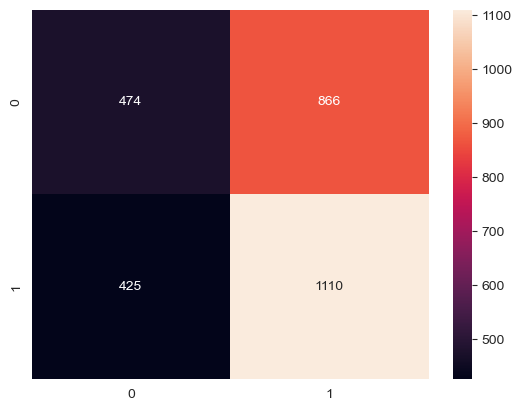

In [53]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.35      0.42      1340
           1       0.56      0.72      0.63      1535

    accuracy                           0.55      2875
   macro avg       0.54      0.54      0.53      2875
weighted avg       0.55      0.55      0.53      2875



In [55]:
def plot_feature_importance(model, X):
    model_importances = pd.DataFrame(model.feature_importances_, columns=['feature_importance'], index=X.columns)
    
    fig = plt.figure(figsize = (20, 30))
    sns.set_style('white')
    ax = sns.barplot(x='feature_importance', 
                y=model_importances.index, 
                data=model_importances, 
                order=model_importances.sort_values(by='feature_importance', ascending=False).index);

    for rect in ax.patches:
        ax.text(rect.get_width() + 0.001, rect.get_y() + rect.get_height() / 2, 
                round(rect.get_width(), 3), verticalalignment='center', fontsize = 11)

    plt.xlabel('Feature importance', fontsize=16);
    plt.ylabel('Feature', fontsize=16);
    
    return model_importances

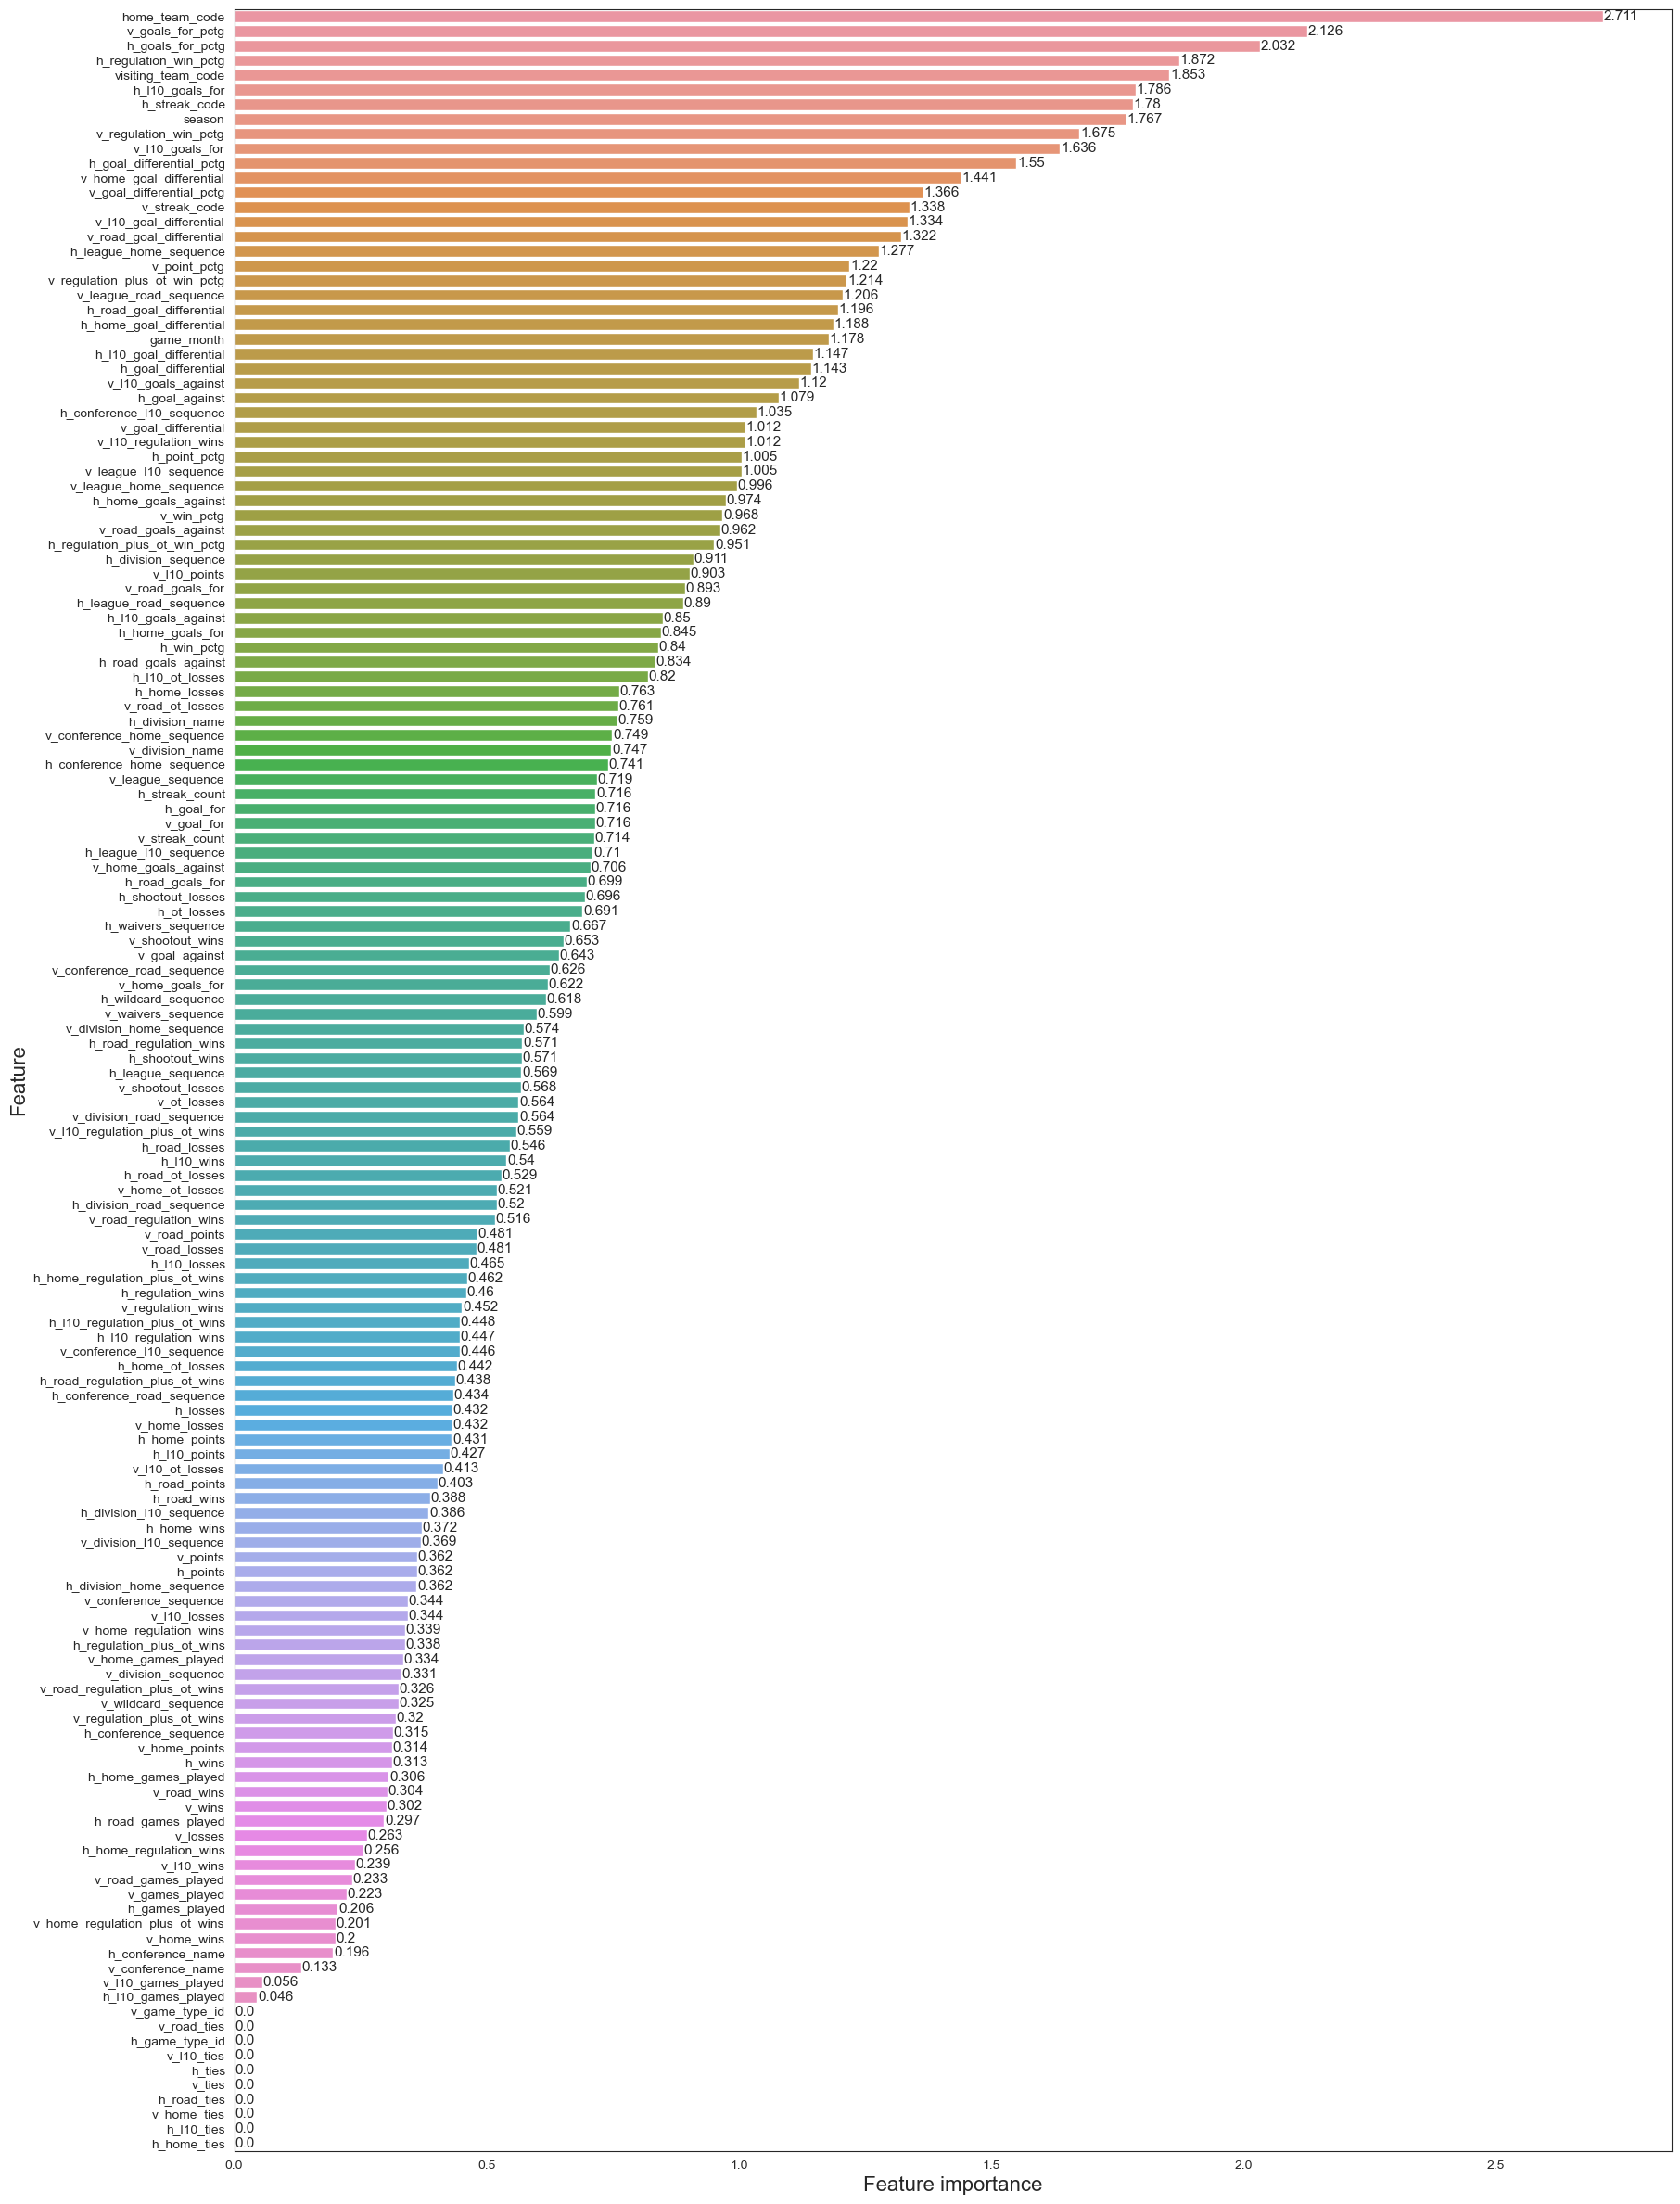

In [56]:
catboost_cl_importance = plot_feature_importance(catboost_cl, X_train)

### Оставим первые 100 фичей

In [87]:
top_100_features = list(catboost_cl_importance.sort_values(by='feature_importance', ascending=False).reset_index().rename(columns={'index': 'feature'}).feature)[:100]

In [88]:
X_train_100 = X_train[top_100_features]
X_test_100 = X_test[top_100_features]

X_train_100.head()

,home_team_code,v_goals_for_pctg,h_goals_for_pctg,h_regulation_win_pctg,visiting_team_code,h_l10_goals_for,h_streak_code,season,v_regulation_win_pctg,v_l10_goals_for,...,h_l10_regulation_wins,v_conference_l10_sequence,h_home_ot_losses,h_road_regulation_plus_ot_wins,h_conference_road_sequence,h_losses,v_home_losses,h_home_points,h_l10_points,v_l10_ot_losses
0,VAN,2.911765,3.307692,0.512821,SJS,32,L,20112012,0.411765,31,...,5,6,1,12,1,13,7,23,13,3
1,CHI,2.702703,3.289474,0.447368,EDM,32,W,20112012,0.378378,24,...,5,15,3,8,3,10,6,31,16,0
2,OTT,2.783784,3.076923,0.307692,NJD,30,W,20112012,0.297297,33,...,2,4,1,5,8,15,6,23,13,0
3,LAK,2.700000,2.205128,0.358974,COL,21,W,20112012,0.300000,30,...,4,2,1,7,5,14,10,23,14,0
4,PHI,2.972222,3.416667,0.527778,NYR,30,W,20112012,0.583333,30,...,6,2,2,14,1,10,3,18,13,0


In [93]:
categorical_features = [
    "season",
    "home_team_code",
    "visiting_team_code",
    # "h_conference_name",
    "h_division_name",
    "h_streak_code",
    # "v_conference_name",
    "v_division_name",
    "v_streak_code"
]

In [94]:
catboost_cl_top_100 = CatBoostClassifier(
                          iterations=10000,
                          random_state=17,
                          cat_features=categorical_features,
                          verbose=100)

catboost_cl_top_100.fit(X_train_100, y_train, verbose=100)

y_pred = catboost_cl_top_100.predict(X_test_100)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Learning rate set to 0.003539
0:	learn: 0.6930228	total: 21.2ms	remaining: 3m 32s
100:	learn: 0.6840328	total: 1.16s	remaining: 1m 53s
200:	learn: 0.6782512	total: 2.57s	remaining: 2m 5s
300:	learn: 0.6742653	total: 3.66s	remaining: 1m 57s
400:	learn: 0.6711547	total: 4.95s	remaining: 1m 58s
500:	learn: 0.6684347	total: 6.06s	remaining: 1m 54s
600:	learn: 0.6662767	total: 7.33s	remaining: 1m 54s
700:	learn: 0.6640777	total: 8.46s	remaining: 1m 52s
800:	learn: 0.6621847	total: 9.76s	remaining: 1m 52s
900:	learn: 0.6603317	total: 10.9s	remaining: 1m 49s
1000:	learn: 0.6585933	total: 12.1s	remaining: 1m 48s
1100:	learn: 0.6569033	total: 13.3s	remaining: 1m 47s
1200:	learn: 0.6553310	total: 14.6s	remaining: 1m 46s
1300:	learn: 0.6537525	total: 15.7s	remaining: 1m 44s
1400:	learn: 0.6521885	total: 16.9s	remaining: 1m 43s
1500:	learn: 0.6506137	total: 18s	remaining: 1m 42s
1600:	learn: 0.6490533	total: 19.3s	remaining: 1m 41s
1700:	learn: 0.6475818	total: 20.4s	remaining: 1m 39s
1800:	learn:

<AxesSubplot:>

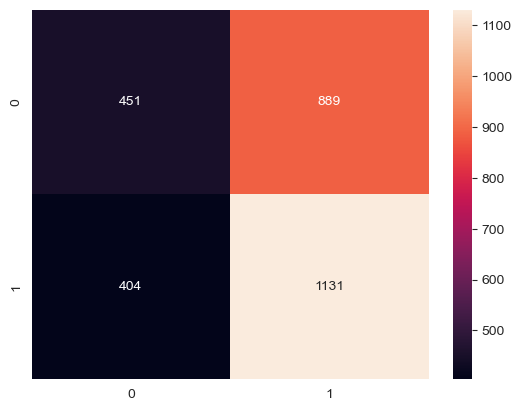

In [95]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [96]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.34      0.41      1340
           1       0.56      0.74      0.64      1535

    accuracy                           0.55      2875
   macro avg       0.54      0.54      0.52      2875
weighted avg       0.54      0.55      0.53      2875



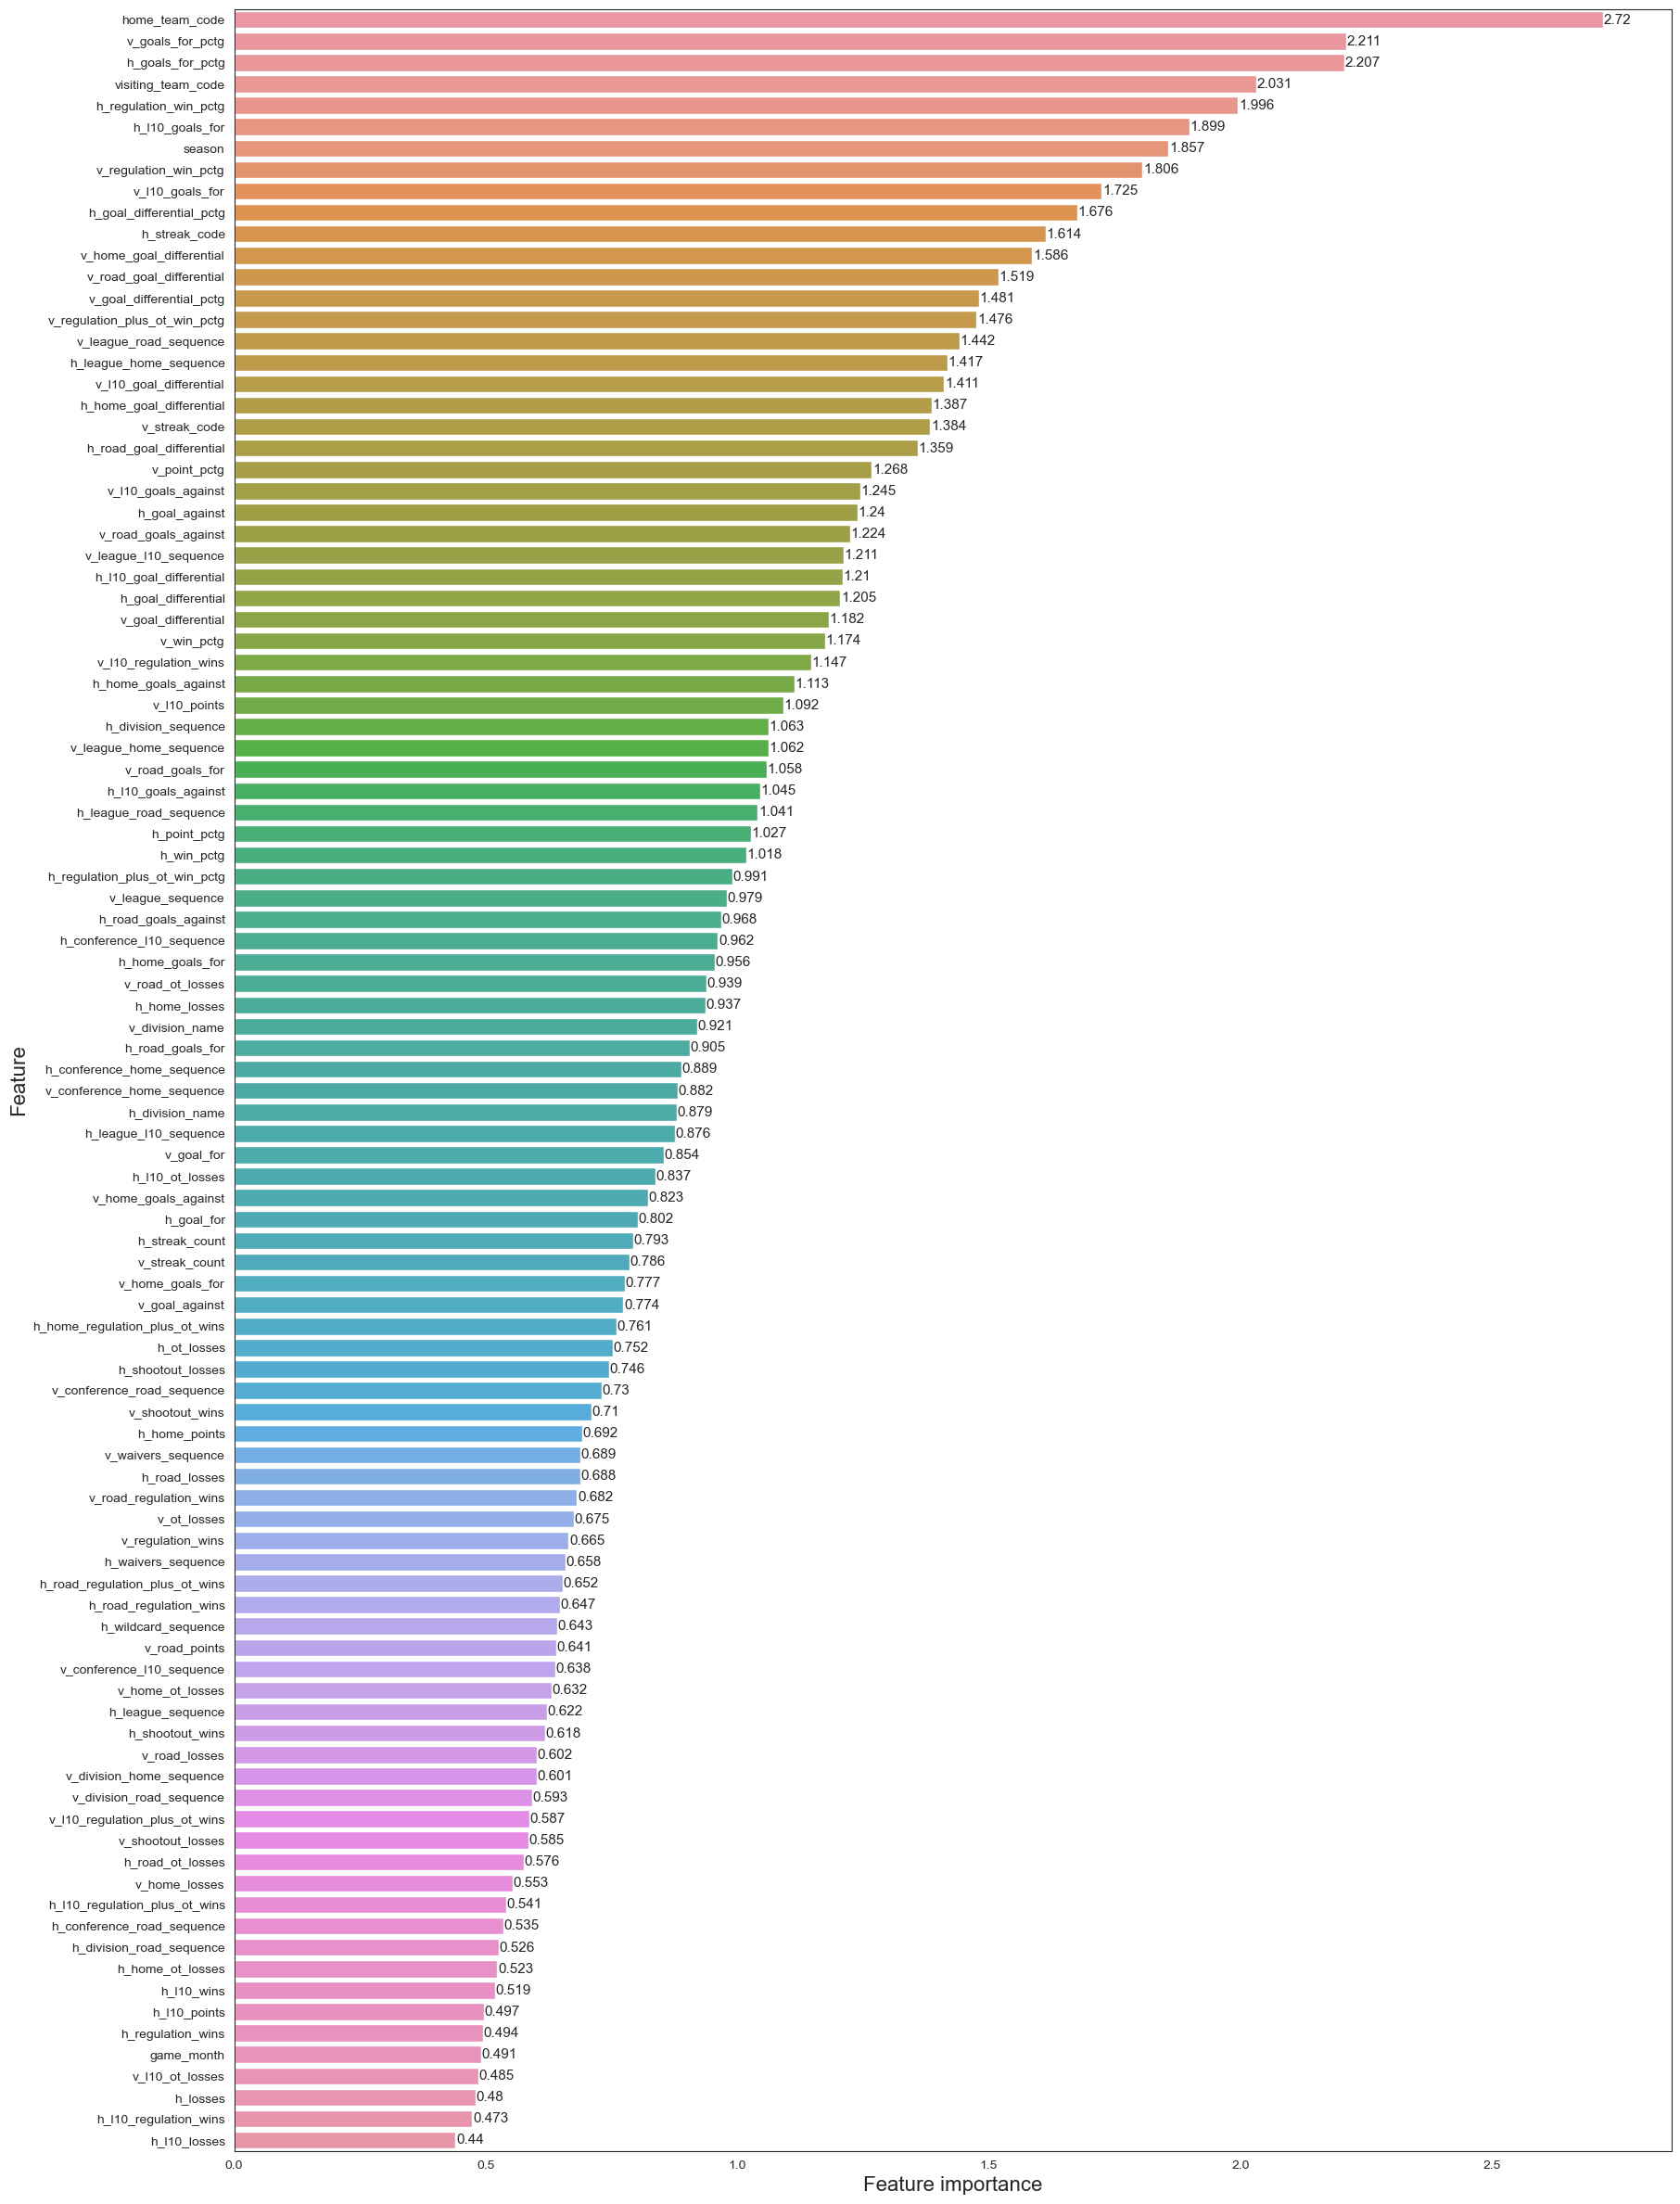

In [97]:
catboost_cl_top_50_importance = plot_feature_importance(catboost_cl_top_100, X_train_100)